In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import HTML
import datetime
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.stats import norm
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import pandas as pd

# Path to your Excel file
file_path = 'Run1.xlsx'
sheet = 'Run1'
# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to verify
print(df.head())



                 Time     PRE  TEMP EXT  TEMP_CULTURE  PAR_LIGHT    PH     DO  \
0 2024-03-27 13:12:00  118.75      20.7          27.0       12.5  8.80  23.57   
1 2024-03-27 13:22:00  118.75      20.7          27.4       12.5  8.83  23.57   
2 2024-03-27 13:32:00  118.75      20.7          27.8       12.5  7.19  23.35   
3 2024-03-27 13:42:00  118.75      20.7          28.1       12.5  7.01  23.87   
4 2024-03-27 13:52:00  118.75      20.7          27.9       12.5  7.20  23.96   

     OD       DRY       CELL  VES  DES  Surface Tension  
0  0.55  0.191455  281000000    0    0                0  
1  0.58  0.201898  297000000    0    0                0  
2  0.62  0.215822  317000000    0    0                0  
3  0.64  0.222784  327000000    0    0                0  
4  0.66  0.229746  337000000    0    0                0  


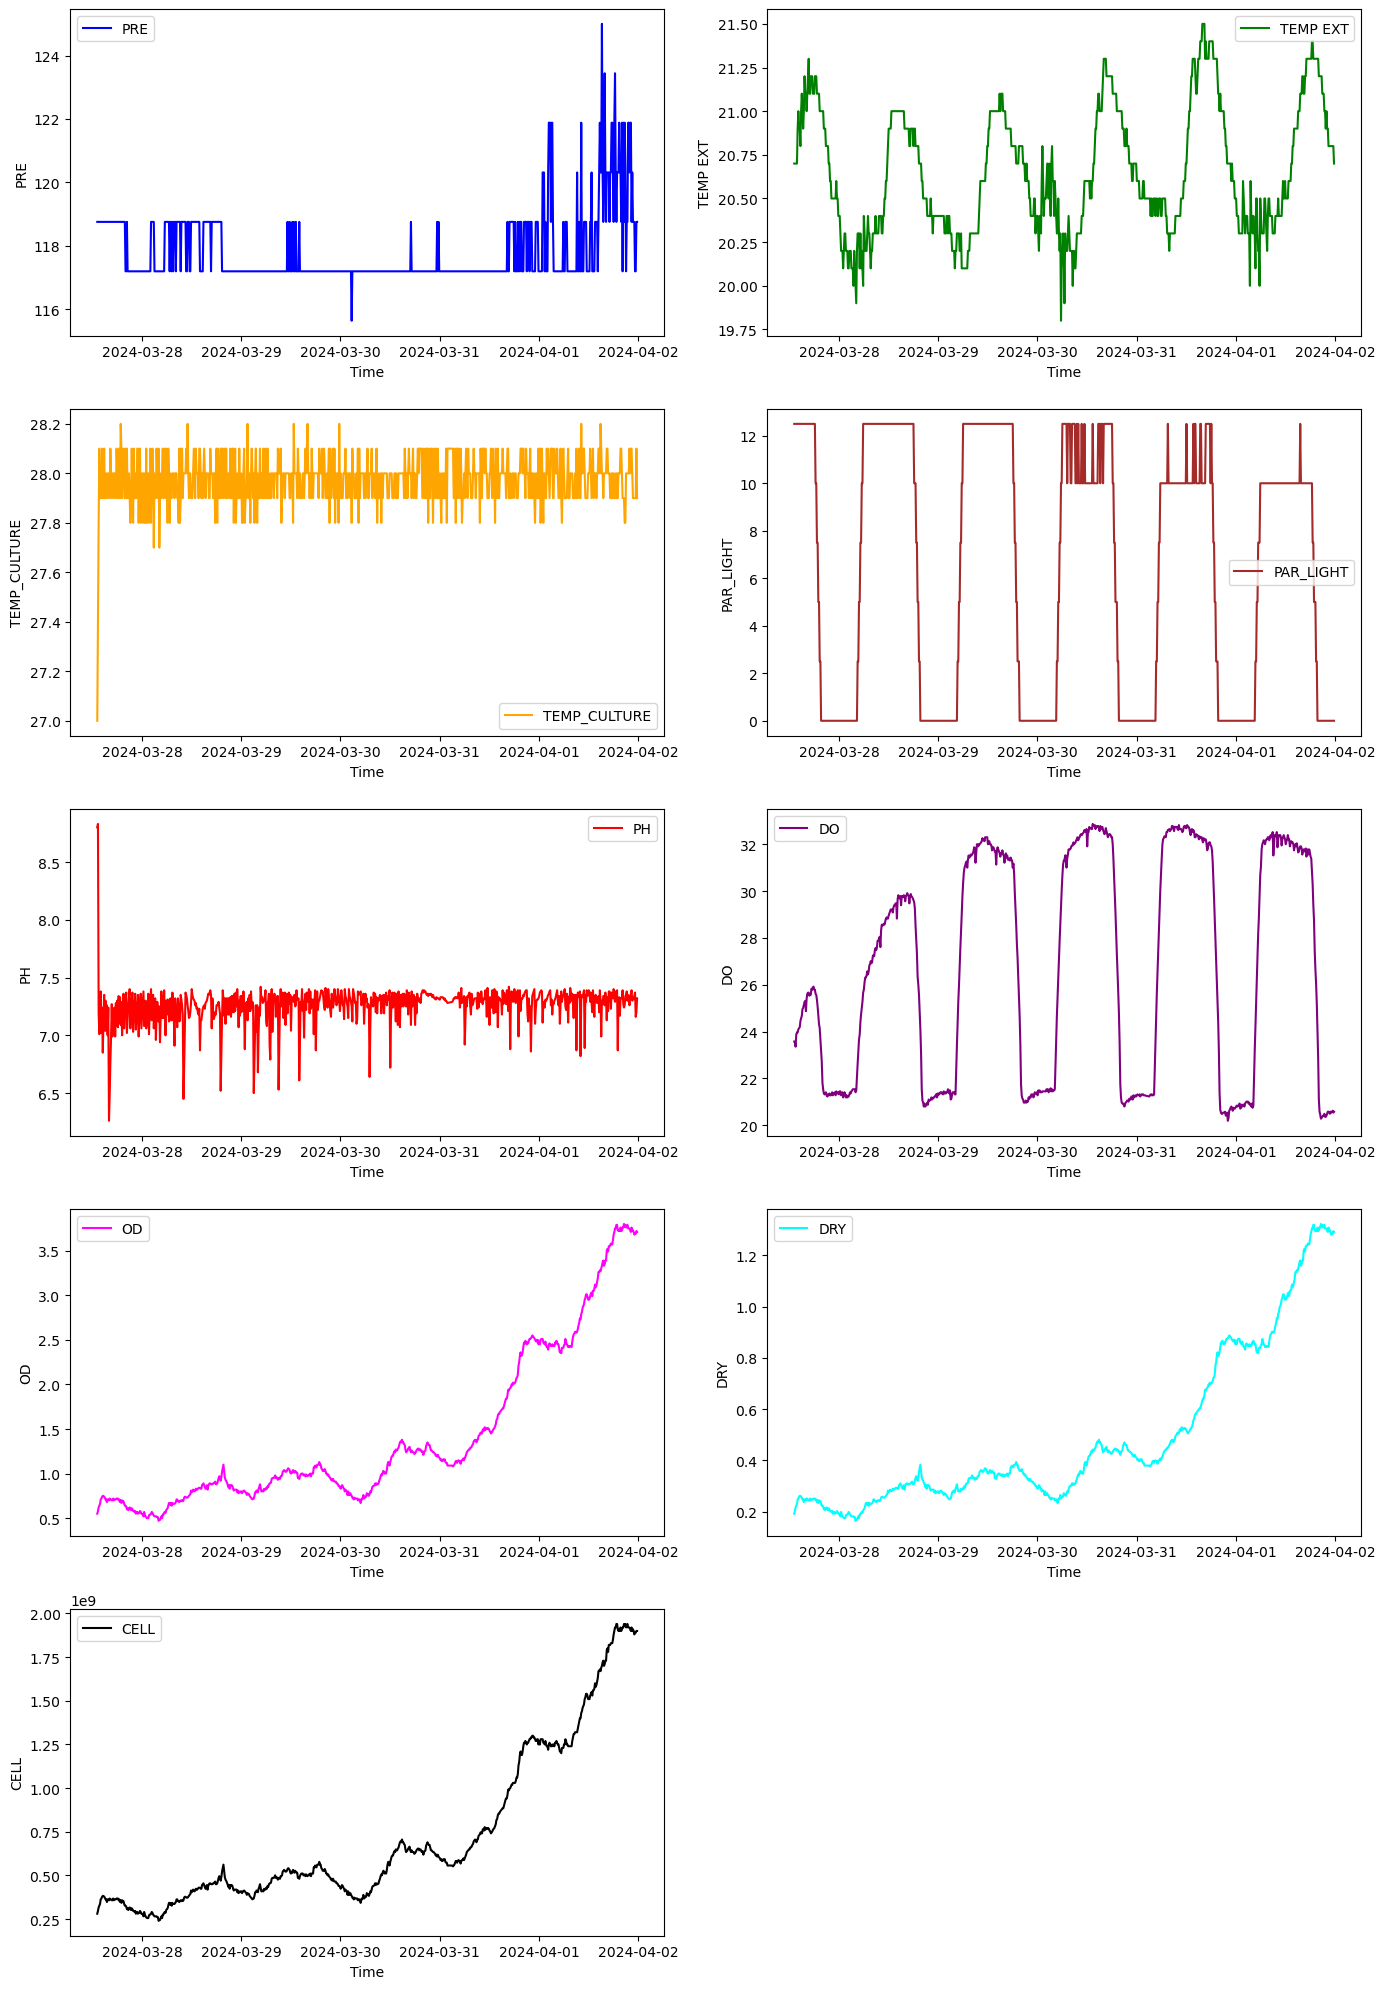

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating subplots with 5 rows and 2 columns
fig, axs = plt.subplots(5, 2, figsize=(14, 20))  # 5 rows, 2 columns

# Flatten the 2D array of axes to easily iterate through them
axs = axs.flatten()

# List of columns to plot
columns = ['PRE', 'TEMP EXT', 'TEMP_CULTURE', 'PAR_LIGHT', 'PH', 'DO', 'OD', 'DRY', 'CELL']

# List of colors for each plot
colors = ['blue', 'green', 'orange', 'brown', 'red', 'purple', 'magenta', 'cyan', 'black']

# Plotting each column against 'Time'
for i, (column, color) in enumerate(zip(columns, colors)):
    axs[i].plot(df['Time'], df[column], label=column, color=color)
    axs[i].set_ylabel(column)
    axs[i].set_xlabel('Time')
    axs[i].legend()

# Remove the last subplot (9th subplot in a 10 plot layout)
fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [4]:
import datetime

# Assuming df is your DataFrame with the 'Time' column
# If 'Time' is not already in datetime format, convert it
df['Time'] = pd.to_datetime(df['Time'])

start_time = datetime.datetime(2024, 3, 1)
end_time = datetime.datetime(2024, 4, 20)

# Filter the DataFrame based on 'Time' between start_time and end_time
dft = df.loc[(df['Time'] >= start_time) & (df['Time'] <= end_time)]

# Now dft contains the rows with 'Time' between start_time and end_time
print(dft)


                       Time     PRE  TEMP EXT  TEMP_CULTURE  PAR_LIGHT    PH  \
0   2024-03-27 13:12:00.000  118.75      20.7          27.0       12.5  8.80   
1   2024-03-27 13:22:00.000  118.75      20.7          27.4       12.5  8.83   
2   2024-03-27 13:32:00.000  118.75      20.7          27.8       12.5  7.19   
3   2024-03-27 13:42:00.000  118.75      20.7          28.1       12.5  7.01   
4   2024-03-27 13:52:00.000  118.75      20.7          27.9       12.5  7.20   
..                      ...     ...       ...           ...        ...   ...   
773 2024-04-01 23:02:10.775  118.75      20.8          27.9        0.0  7.34   
774 2024-04-01 23:12:11.265  117.19      20.8          27.9        0.0  7.37   
775 2024-04-01 23:22:11.755  117.19      20.8          27.9        0.0  7.16   
776 2024-04-01 23:32:12.245  118.75      20.8          28.1        0.0  7.20   
777 2024-04-01 23:42:12.735  118.75      20.7          27.9        0.0  7.32   

        DO    OD       DRY        CELL 

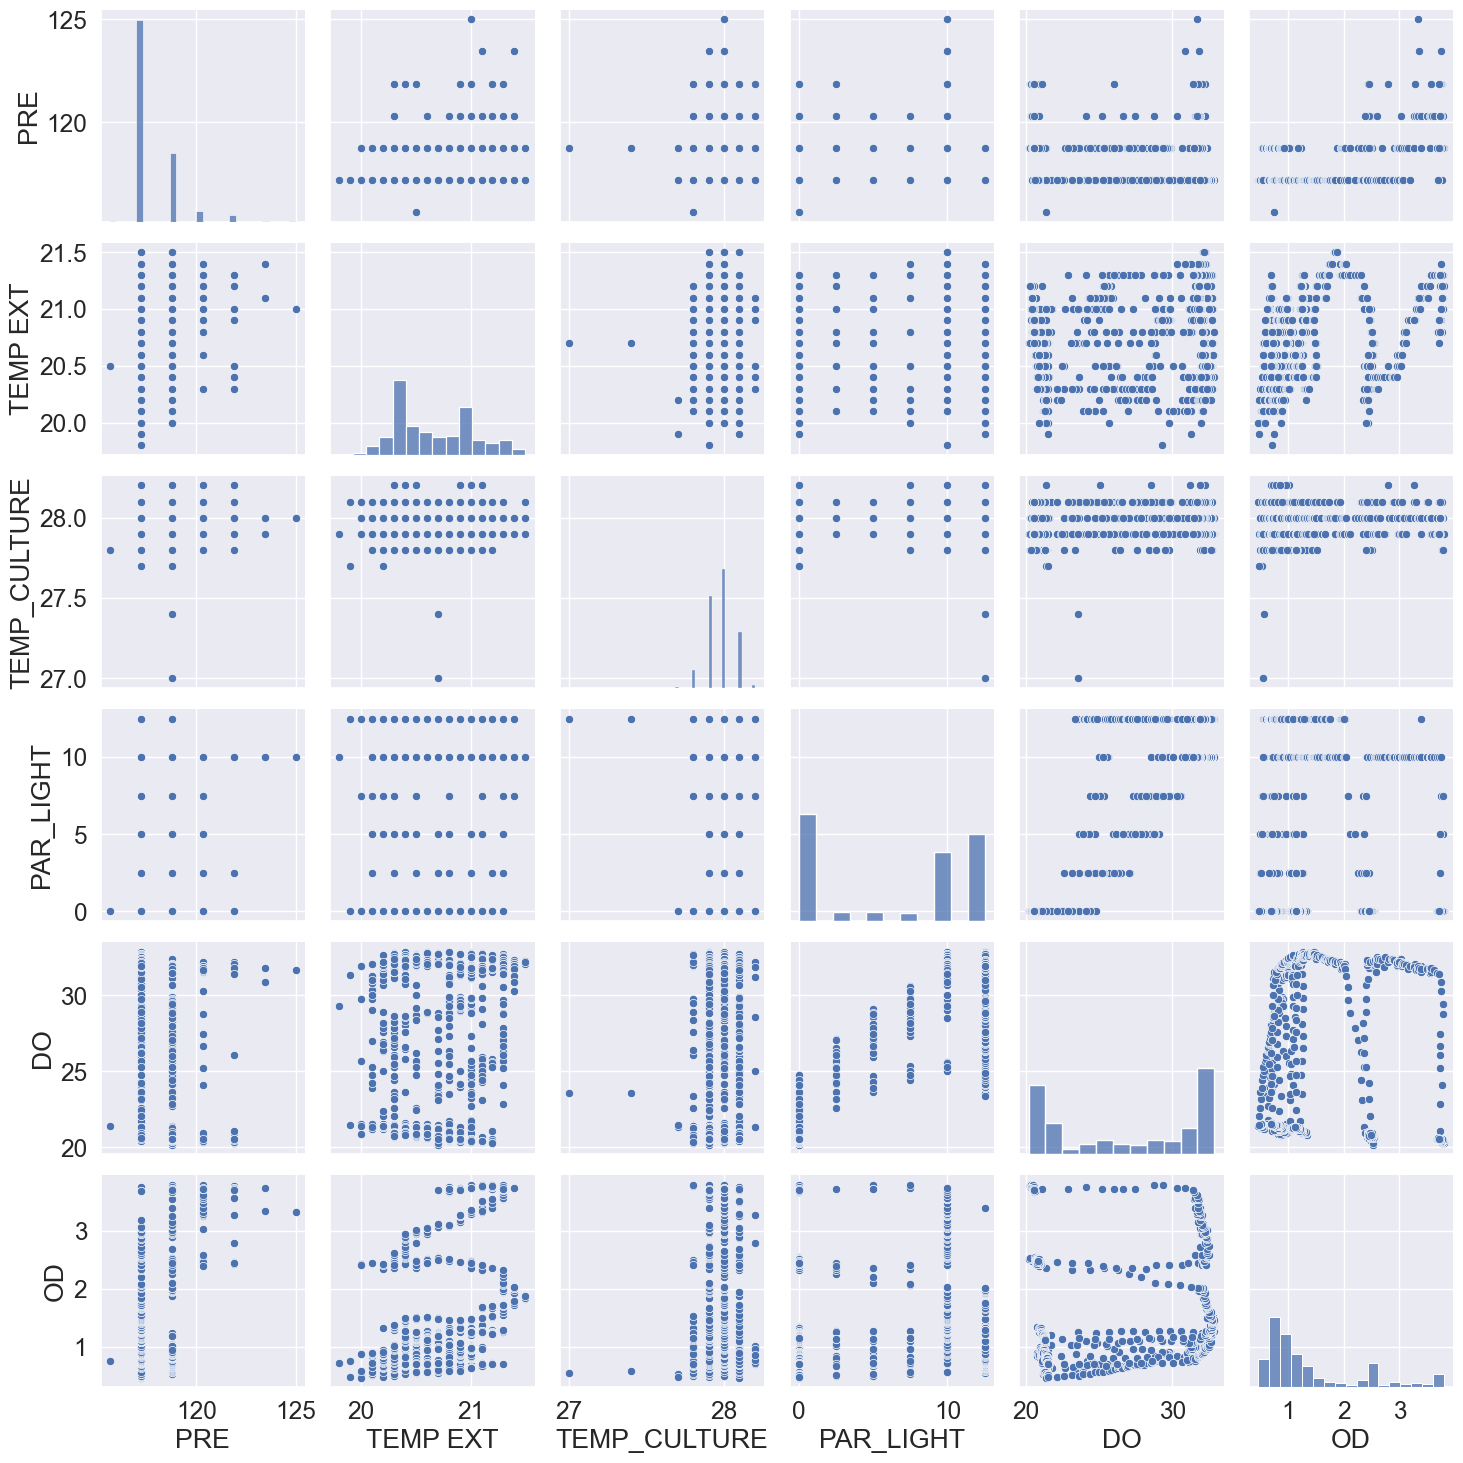

In [5]:
# Assuming df is your DataFrame with the 'Time' column
# Drop the 'Time' column
dftw = dft.drop(columns=['Time','VES','DES','Surface Tension','DRY','CELL','PH'])
sns.set(font_scale=1.6)  # Adjust the font scale as needed
# Create a pairplot
sns.pairplot(dftw)
plt.show()


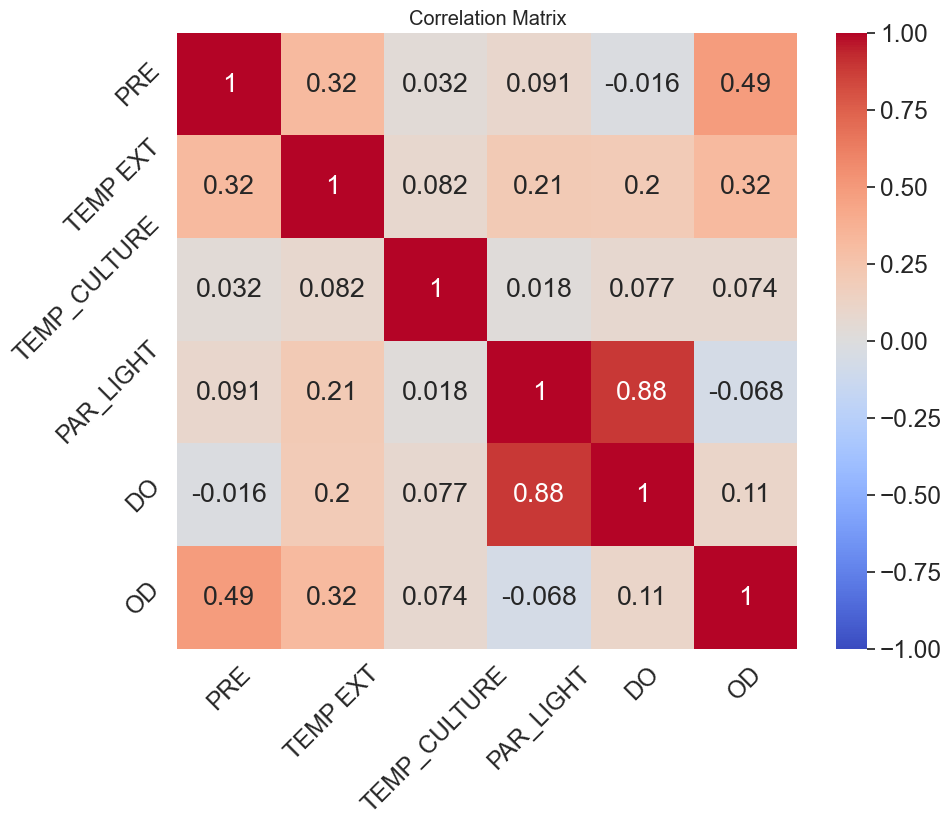

In [6]:
# Assuming df_without_time is your DataFrame without the 'Time' column
# Calculate the correlation matrix
correlation_matrix = dftw.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
sns.set(font_scale=1.2)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


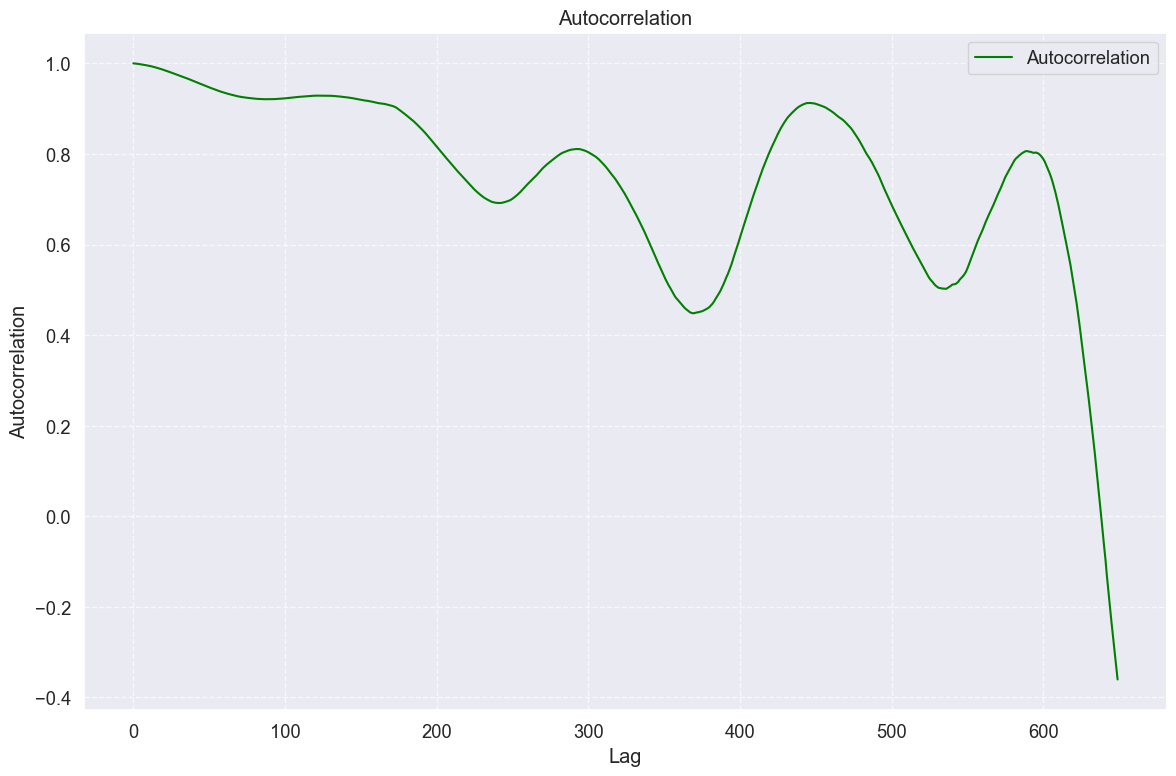

In [7]:
# Combine all batches into one dataset
ac = dftw['OD'].copy()

# Set the maximum lag
max_lag = 650

# Calculate autocorrelation for the combined dataset
autocorr = [ac.autocorr(lag=l) for l in range(max_lag)]

# Plot the autocorrelation for the combined dataset
plt.figure(figsize=(12, 8))
plt.plot(np.arange(max_lag), autocorr, label='Autocorrelation', color='green')

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# LSTM on OD

C:\Users\morebo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\morebo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\morebo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\morebo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\morebo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Mean MSE: 0.00 ± 0.00
Mean MAE: 0.03 ± 0.01
Mean R2: 0.96 ± 0.03
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7790e-05
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5741e-05
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6307e-05
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2875e-05
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0580e-05
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1816e-05
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7293e-05
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2441e-05
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5172e-05
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0945e-05
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7755e-05 
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2432e-05
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4357e-05
Epoch 78/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1448e-05
Epoch 79/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4914e-05
Epoch 80/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0313e-05
Epoch 81/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6274e-05
Epoch 82/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2710e-05
Epoch 83/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4103e-05
Epoch 84/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8880e-05
Epoch 85/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5266e-05
Epoch 86/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0995e-05
Epoch 87/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0362e-05
Epoch 88/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7562e-05
Epoch 89/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0256e-05
Epoch 90/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9062e-05
Epoch 91/100
49/49 

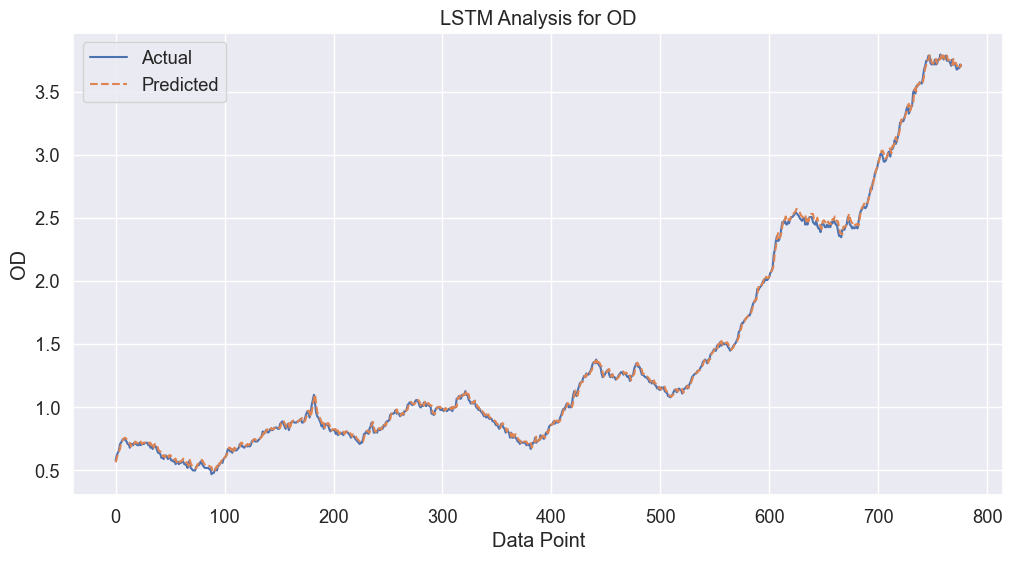

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming dftw is your dataset and 'OD' is the feature you want to predict
data = dftw[['OD']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create time series data with lookback
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Define the lookback window
look_back = 1

# Create the time series dataset
X, y = create_dataset(data_scaled, look_back)

# Reshape the input data for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)
mse_scores, mae_scores, r2_scores = [], [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=10, input_shape=(X.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Inverse transform to get actual values
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Calculate mean and standard deviation of the evaluation metrics
mse_mean, mse_std = np.mean(mse_scores), np.std(mse_scores)
mae_mean, mae_std = np.mean(mae_scores), np.std(mae_scores)
r2_mean, r2_std = np.mean(r2_scores), np.std(r2_scores)

print(f'Mean MSE: {mse_mean:.2f} ± {mse_std:.2f}')
print(f'Mean MAE: {mae_mean:.2f} ± {mae_std:.2f}')
print(f'Mean R2: {r2_mean:.2f} ± {r2_std:.2f}')

# Final model training with all data
model.fit(X, y, epochs=100, batch_size=16)

# Final model evaluation on the whole data set
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='dashed')
plt.title('LSTM Analysis for OD')
plt.xlabel('Data Point')
plt.ylabel('OD')
plt.legend()
plt.show()


# Add Noise to the data

In [16]:
# Function to add Gaussian noise
def add_noise(data, noise_factor):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=data.shape)
    return data + noise

# Adding noise to the scaled data
noise_factor = 0.04  # Adjust the noise factor to increase or decrease noise
data_noisy = add_noise(data_scaled, noise_factor)

# Make sure the noisy data stays within the original scale limits
data_noisy = np.clip(data_noisy, 0, 1)


# Create Noisy Datasets

In [17]:
train_size = int(len(X) * 0.8)
X_noisy, y_noisy = create_dataset(data_noisy, look_back)

# Reshape the input data for LSTM
X_noisy = np.reshape(X_noisy, (X_noisy.shape[0], X_noisy.shape[1], 1))

# Split the noisy data into training and testing sets
X_train_noisy, X_test_noisy = X_noisy[:train_size], X_noisy[train_size:]
y_train_noisy, y_test_noisy = y_noisy[:train_size], y_noisy[train_size:]


# Evaluate the Model on Noisy Data

In [18]:
# Make predictions on the noisy test set
y_pred_noisy = model.predict(X_test_noisy)
y_pred_noisy = scaler.inverse_transform(y_pred_noisy)
y_test_noisy = scaler.inverse_transform(y_test_noisy.reshape(-1, 1))

# Quantitative Evaluation on Noisy Data
mse_noisy = mean_squared_error(y_test_noisy, y_pred_noisy)
mae_noisy = mean_absolute_error(y_test_noisy, y_pred_noisy)
rmse_noisy = np.sqrt(mse_noisy)
r2_noisy = r2_score(y_test_noisy, y_pred_noisy)
mape_noisy = np.mean(np.abs((y_test_noisy - y_pred_noisy) / y_test_noisy)) * 100

print(f'Noisy Data - Mean Squared Error (MSE): {mse_noisy:.2f}')
print(f'Noisy Data - Mean Absolute Error (MAE): {mae_noisy:.2f}')
print(f'Noisy Data - Root Mean Squared Error (RMSE): {rmse_noisy:.2f}')
print(f'Noisy Data - R-squared (R2): {r2_noisy:.2f}')
print(f'Noisy Data - MAPE: {mape_noisy:.2f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Noisy Data - Mean Squared Error (MSE): 0.03
Noisy Data - Mean Absolute Error (MAE): 0.14
Noisy Data - Root Mean Squared Error (RMSE): 0.18
Noisy Data - R-squared (R2): 0.89
Noisy Data - MAPE: 5.00


# Plotting Noisy Predictions

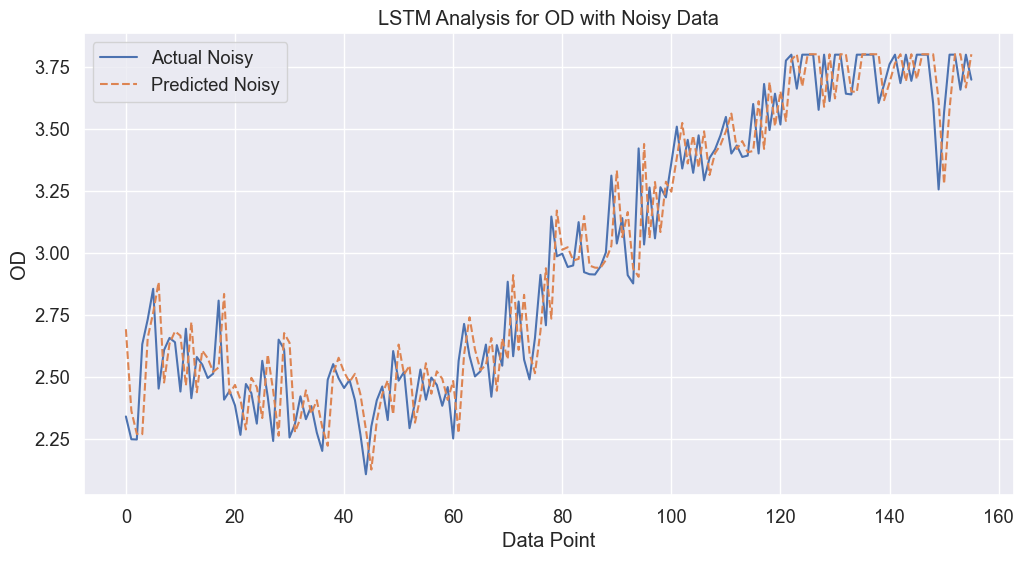

In [19]:
# Plot the noisy results
plt.figure(figsize=(12, 6))
plt.plot(y_test_noisy, label='Actual Noisy')
plt.plot(y_pred_noisy, label='Predicted Noisy', linestyle='dashed')
plt.title('LSTM Analysis for OD with Noisy Data')
plt.xlabel('Data Point')
plt.ylabel('OD')
plt.legend()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
New Data - Mean Squared Error (MSE): 0.00
New Data - Mean Absolute Error (MAE): 0.03
New Data - Root Mean Squared Error (RMSE): 0.04
New Data - R-squared (R2): 1.00
New Data - MAPE: 12.27


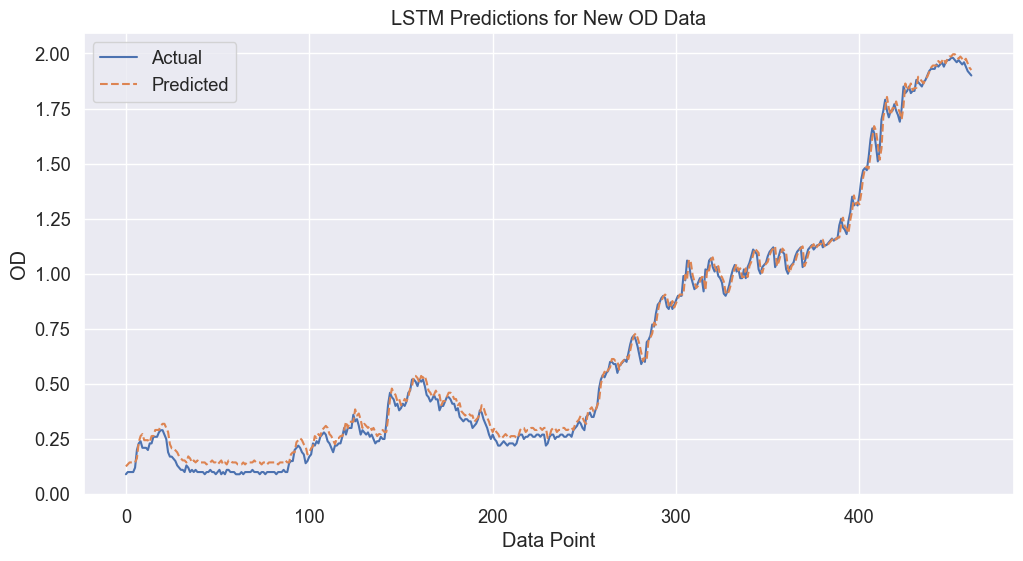

In [26]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Load the new dataset
file_path = 'Run2.xlsx'
sheet = 'Run2'
df2 = pd.read_excel(file_path, sheet_name=sheet)

# Convert 'Time' column to datetime
df2['Time'] = pd.to_datetime(df2['Time'])

# Define the date range for filtering
start_time = datetime.datetime(2024, 3, 1)
end_time = datetime.datetime(2024, 4, 29)

# Filter the data based on 'Time'
dft2 = df2.loc[(df2['Time'] >= start_time) & (df2['Time'] <= end_time)]
dftw2 = dft2.drop(columns=['Time', 'VES', 'DES', 'Surface Tension', 'DRY', 'CELL', 'PH'])

# Extract 'OD' feature and scale the data using the same scaler
data2 = dftw2[['OD']].values
data_scaled2 = scaler.transform(data2)  # Assuming 'scaler' was defined and fitted on the training data

# Function to create time series data with lookback
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Define the lookback window used during training
look_back = 1

# Create the time series dataset
X_new, y_new = create_dataset(data_scaled2, look_back)

# Reshape the input data for LSTM
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

# Load the trained model
# model = load_model('path_to_your_saved_model.h5') # Uncomment if loading a saved model

# Make predictions on the new data
y_pred_new = model.predict(X_new)
y_pred_new = scaler.inverse_transform(y_pred_new)
y_actual_new = scaler.inverse_transform(y_new.reshape(-1, 1))

# Quantitative Evaluation
mse_new = mean_squared_error(y_actual_new, y_pred_new)
mae_new = mean_absolute_error(y_actual_new, y_pred_new)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_actual_new, y_pred_new)
mape_new = np.mean(np.abs((y_actual_new - y_pred_new) / y_actual_new)) * 100

print(f'New Data - Mean Squared Error (MSE): {mse_new:.2f}')
print(f'New Data - Mean Absolute Error (MAE): {mae_new:.2f}')
print(f'New Data - Root Mean Squared Error (RMSE): {rmse_new:.2f}')
print(f'New Data - R-squared (R2): {r2_new:.2f}')
print(f'New Data - MAPE: {mape_new:.2f}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_actual_new, label='Actual')
plt.plot(y_pred_new, label='Predicted', linestyle='dashed')
plt.title('LSTM Predictions for New OD Data')
plt.xlabel('Data Point')
plt.ylabel('OD')
plt.legend()
plt.show()
